## Prostate158 - Eploratory data analysis

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import scipy.ndimage as ndi
import pandas as pd
import os
import copy

In [4]:
train_dir = '../input/prostate15/prostate158_train/prostate158_train'
train_csv = os.path.join(train_dir, 'train.csv')
train_valid_csv = os.path.join(train_dir, 'valid.csv')

test_dir = '../input/prostate15/prostate158_test/prostate158_test'
test_csv = os.path.join(test_dir, 'test.csv')

In [5]:
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(train_valid_csv)
test_df = pd.read_csv(test_csv)

train_df.head()

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii.gz,train/024/adc.nii.gz,train/024/dwi.nii.gz,train/024/t2_anatomy_reader1.nii.gz,NaN,train/024/empty.nii.gz,NaN,NaN
1,25,train/025/t2.nii.gz,train/025/adc.nii.gz,train/025/dwi.nii.gz,train/025/t2_anatomy_reader1.nii.gz,train/025/t2_tumor_reader1.nii.gz,train/025/adc_tumor_reader1.nii.gz,NaN,train/025/adc_tumor_reader2.nii.gz
2,26,train/026/t2.nii.gz,train/026/adc.nii.gz,train/026/dwi.nii.gz,train/026/t2_anatomy_reader1.nii.gz,NaN,train/026/empty.nii.gz,NaN,NaN
3,27,train/027/t2.nii.gz,train/027/adc.nii.gz,train/027/dwi.nii.gz,train/027/t2_anatomy_reader1.nii.gz,train/027/t2_tumor_reader1.nii.gz,train/027/adc_tumor_reader1.nii.gz,NaN,train/027/adc_tumor_reader2.nii.gz
4,28,train/028/t2.nii.gz,train/028/adc.nii.gz,train/028/dwi.nii.gz,train/028/t2_anatomy_reader1.nii.gz,NaN,train/028/empty.nii.gz,NaN,NaN


In [6]:
import math

def remove_compression_suffix(df):
    columns = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 't2_anatomy_reader2', 'adc_tumor_reader2']
    df[columns] = df[columns].map(lambda v: '.'.join(x for x in v.split('.')[:-1]) if isinstance(v, str) else v)
    return df

train_df = remove_compression_suffix(train_df)
valid_df = remove_compression_suffix(valid_df)
test_df = remove_compression_suffix(test_df)
train_df.head()

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii,train/024/adc.nii,train/024/dwi.nii,train/024/t2_anatomy_reader1.nii,NaN,train/024/empty.nii,NaN,NaN
1,25,train/025/t2.nii,train/025/adc.nii,train/025/dwi.nii,train/025/t2_anatomy_reader1.nii,train/025/t2_tumor_reader1.nii,train/025/adc_tumor_reader1.nii,NaN,train/025/adc_tumor_reader2.nii
2,26,train/026/t2.nii,train/026/adc.nii,train/026/dwi.nii,train/026/t2_anatomy_reader1.nii,NaN,train/026/empty.nii,NaN,NaN
3,27,train/027/t2.nii,train/027/adc.nii,train/027/dwi.nii,train/027/t2_anatomy_reader1.nii,train/027/t2_tumor_reader1.nii,train/027/adc_tumor_reader1.nii,NaN,train/027/adc_tumor_reader2.nii
4,28,train/028/t2.nii,train/028/adc.nii,train/028/dwi.nii,train/028/t2_anatomy_reader1.nii,NaN,train/028/empty.nii,NaN,NaN


### Columns' description&ast;
* **ID** – patient MRI identificator
* **t2** – t2 sequence in NIfTI format
* **adc** – ADC sequence in NIfTI format
* **dwi** – DWI sequence in NIfTI format
* **t2_anatomy_reader1** – Anatomy segmentation of reader 1
* **t2_anatomy_reader2** – Anatomy segmentation of reader 2&ast;&ast;
* **t2_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader2** – Tumor segmentation of reader 2

<details>
    <summary>Abbreviations</summary>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Apparent diffusion coefficient?</a>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Diffusion-weighted imaging?</a>
</details>

###### &ast;Based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9679750/pdf/main.pdf, &ast;&ast;own caption


### Half CASEs of the training data seems not to have cancerous lesions

In [7]:
for label, df in {'Train Set': train_df, 'Training Validation Set': valid_df, 'Test Set': test_df}.items():
    na_vals = pd.isna(df).sum()
    percent_missing = na_vals / df.shape[0]
    percent_missing = percent_missing.apply(lambda x: f"{x:.2%}")
    print(label)
    print(pd.DataFrame({'count missing': na_vals, 'percent_missing': percent_missing}).sort_values(by='count missing', ascending=False))
    print('\n' * 2)

Train Set
                    count missing percent_missing
t2_anatomy_reader2            119         100.00%
adc_tumor_reader2              62          52.10%
t2_tumor_reader1               49          41.18%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_reader1               0           0.00%



Training Validation Set
                    count missing percent_missing
t2_anatomy_reader2             20         100.00%
adc_tumor_reader2              10          50.00%
t2_tumor_reader1                8          40.00%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_rea

### Samples visualisation

In [165]:
def load_nii(f_name, dir=train_dir):
    if (isinstance(f_name, str) == False):
        raise Exception(f'Invalid filepath "{f_name}"" is not a string')
    img = nib.load(os.path.join(dir, f_name))
    data = img.get_fdata()
    return (img, data)

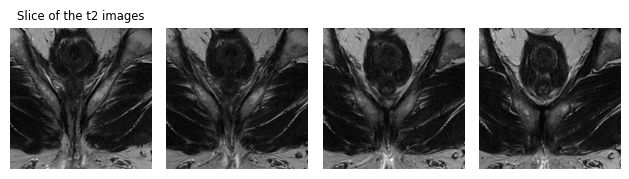

In [166]:
t2, t2_data = load_nii(train_df.iloc[2]['t2'])
t2_slice = t2_data[:, :, 4:8]
img_count = t2_data_slice.shape[-1]
fig, axs = plt.subplots(1, 4)
for i in range(img_count):
    axs.flat[i].imshow(ndi.rotate(t2_slice[:,:,i], 90), cmap='gray')
    axs.flat[i].axis('off')
    
axs.flat[0].set_title('Slice of the t2 images', size='small')
plt.tight_layout()
plt.axis('off')
plt.show()

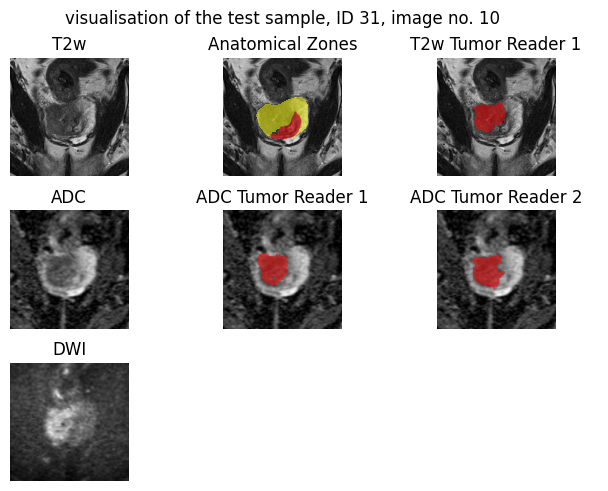

In [242]:
CASE = 7
SET = train_df
SELECTED_IMG = 10

data_files = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2']
data = {key: load_nii(SET.iloc[CASE][key])[1] for key in data_files}

def process_slice(data, selected_image, mask=False):
    img_slice = data[:, :, selected_image]
    img_slice = np.rot90(img_slice)
    if mask:
        img_slice = np.ma.masked_where(img_slice == 0, img_slice)
    return img_slice

t2_slice, dwi_slice, adc_slice = [process_slice(data[fname], SELECTED_IMG) for fname in ('t2', 'dwi', 'adc')]
t2_ar1_slice, t2_tr1_slice, adc_tr1_slice, adc_tr2_slice = [process_slice(data[fname], SELECTED_IMG, mask=True) for fname in ('t2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2')]

fig = plt.figure(constrained_layout=True)
fig.suptitle(f'visualisation of the test sample, ID {SET.iloc[CASE]["ID"]}, image no. {SELECTED_IMG}')
subfigs = fig.subfigures(3, 1)

def plot_images(axs, titles, base_img, overlay_imgs=None, overlay_alpha=0.5, cmap='gray', overlay_cmap='autumn'):
    for ax, title, overlay in zip(axs, titles, overlay_imgs or (None for _ in axs)):
        ax.set_title(title)
        ax.imshow(base_img, cmap=cmap)
        if overlay is not None:
            ax.imshow(overlay, alpha=overlay_alpha, cmap=overlay_cmap)
        ax.axis('off')


axsTop = subfigs[0].subplots(1, 3)
plot_images(axsTop, ['T2w', 'Anatomical Zones', 'T2w Tumor Reader 1'], t2_slice, [None, t2_ar1_slice, t2_tr1_slice])

axsMiddle = subfigs[1].subplots(1, 3)
plot_images(axsMiddle, ['ADC', 'ADC Tumor Reader 1', 'ADC Tumor Reader 2'], adc_slice, [None, adc_tr1_slice, adc_tr2_slice])

axsBottom = subfigs[2].subplots(1, 3)
plot_images(axsBottom, ['DWI'], dwi_slice)
for ax in axsBottom[1:]:
    ax.axis('off')

plt.show()